<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Vectorizing-text" data-toc-modified-id="Vectorizing-text-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Vectorizing text</a></span></li><li><span><a href="#TF-IDF-on-ngrams" data-toc-modified-id="TF-IDF-on-ngrams-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TF-IDF on ngrams</a></span></li><li><span><a href="#Pre-trained-word-embeddings" data-toc-modified-id="Pre-trained-word-embeddings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-trained word embeddings</a></span></li></ul></div>

# Vectorizing text

Vectorizing text
As you may expect it, the goal of vectorizing text is to transform text input into a numerical representation. Ideally, this numerical representation should carry semantic meaning that make it easier for an ML model to detect patterns in a corpus of text.

There are multiple ways to vectorize text. I'll demonstrate two here:

- TF-IDF, which builds vectors for documents based on relative word frequency within the given corpus
- Pretrained models which leverage information from other corpuses

We start by loading the data, and getting a training and test split as we saw in [splitting data](ch4_3_splitting_data.ipynb).

In [1]:
import pandas as pd
import spacy
import umap
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

from ml_editor.ch4_data_processing  import format_raw_df, get_split_by_author
from ml_editor.ch4_data_visualization import plot_embeddings 

In [2]:
data_path = Path('../raw_data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

In [3]:
df.head(2)

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,ContentLicense,CreationDate,FavoriteCount,...,Tags,Title,ViewCount,body_text,is_question,Id_question,Title_question,body_text_question,Score_question,AcceptedAnswerId_question
Id,,,,,,,,,,,,,,,,,,,,,
1,0,15.0,10,<p>I've always wanted to start writing (in a t...,2019-09-09T15:44:30.727,7,NaN,CC BY-SA 3.0,2010-11-18T20:40:32.857,19.0,...,<resources><first-time-author>,What are some online guides for starting writers?,1470.0,I've always wanted to start writing (in a tota...,True,NaN,NaN,NaN,NaN,NaN
2,1,16.0,7,<p>What kind of story is better suited for eac...,NaN,0,NaN,CC BY-SA 3.0,2010-11-18T20:42:31.513,5.0,...,<fiction><grammatical-person><third-person>,What is the difference between writing in the ...,9660.0,What kind of story is better suited for each p...,True,NaN,NaN,NaN,NaN,NaN


In [4]:
df['AcceptedAnswerId_question'].value_counts()

988.0      26
27225.0    25
142.0      23
42428.0    22
2923.0     22
           ..
28177.0     1
4823.0      1
48480.0     1
24786.0     1
3568.0      1
Name: AcceptedAnswerId_question, Length: 5191, dtype: int64

In [5]:
train_author, test_author = get_split_by_author(df[df['is_question']])

In [6]:
train_author.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7310 entries, 3 to 53935
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 7310 non-null   int64  
 1   AcceptedAnswerId           3751 non-null   float64
 2   AnswerCount                7310 non-null   int32  
 3   Body                       7310 non-null   object 
 4   ClosedDate                 981 non-null    object 
 5   CommentCount               7310 non-null   int64  
 6   CommunityOwnedDate         15 non-null     object 
 7   ContentLicense             7310 non-null   object 
 8   CreationDate               7310 non-null   object 
 9   FavoriteCount              2901 non-null   float64
 10  Id                         7310 non-null   int32  
 11  LastActivityDate           7310 non-null   object 
 12  LastEditDate               4582 non-null   object 
 13  LastEditorDisplayName      152 non-null    obje

In [7]:
test_author.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2945 entries, 1 to 53922
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 2945 non-null   int64  
 1   AcceptedAnswerId           1440 non-null   float64
 2   AnswerCount                2945 non-null   int32  
 3   Body                       2945 non-null   object 
 4   ClosedDate                 363 non-null    object 
 5   CommentCount               2945 non-null   int64  
 6   CommunityOwnedDate         2 non-null      object 
 7   ContentLicense             2945 non-null   object 
 8   CreationDate               2945 non-null   object 
 9   FavoriteCount              1206 non-null   float64
 10  Id                         2945 non-null   int32  
 11  LastActivityDate           2945 non-null   object 
 12  LastEditDate               1776 non-null   object 
 13  LastEditorDisplayName      38 non-null     obje

In [8]:
train_author['AcceptedAnswerId_question'].value_counts()

Series([], Name: AcceptedAnswerId_question, dtype: int64)

In [9]:
train_author['AcceptedAnswerId'].value_counts()

47347.0    1
6481.0     1
45031.0    1
41108.0    1
30526.0    1
          ..
42850.0    1
33542.0    1
37788.0    1
44004.0    1
31.0       1
Name: AcceptedAnswerId, Length: 3751, dtype: int64

In [10]:
train_author['Id_question'].value_counts()

Series([], Name: Id_question, dtype: int64)

In [11]:
train_author['Title_question'].value_counts()

Series([], Name: Title_question, dtype: int64)

In [12]:
train_author['body_text_question'].value_counts()

Series([], Name: body_text_question, dtype: int64)

In [13]:
train_author['Score_question'].value_counts()

Series([], Name: Score_question, dtype: int64)

In [14]:
test_author['AcceptedAnswerId_question'].value_counts(), test_author['Id_question'].value_counts(),  test_author['Title_question'].value_counts(), test_author['Score_question'].value_counts(), test_author['body_text_question'].value_counts()

(Series([], Name: AcceptedAnswerId_question, dtype: int64),
 Series([], Name: Id_question, dtype: int64),
 Series([], Name: Title_question, dtype: int64),
 Series([], Name: Score_question, dtype: int64),
 Series([], Name: body_text_question, dtype: int64))

# TF-IDF on ngrams

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) creates embeddings based on the relative frequency of each word in each document as compared to the corpus as a whole. We create TF-IDF embeddings using sklearn below.

In [15]:
questions = train_author[train_author['is_question']]
raw_text = questions['body_text']

In [16]:
# Extract a label to use as a color on our plots. 
# This label does not need to be the same label as the one for the classifier.

sent_labels = questions['AcceptedAnswerId'].notna()
sent_labels.value_counts()

True     3751
False    3559
Name: AcceptedAnswerId, dtype: int64

In [17]:
# Create an instance of a tfidf vectorizer, 
# We could use CountVectorizer for a non normalized version

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)

# Fit our vectorizer to questions in our dataset
# Returns an array of vectorized text

bag_of_words = vectorizer.fit_transform(raw_text)
bag_of_words.shape

(7310, 33694)

We have now vectorized our text. This process is also called embedding, and the resulting vectors are often referred to as embeddings. We can visualize the embeddings by projecting them to two dimensions using a dimensionality reducing technique such as PCA, t-SNE or UMAP. We use [UMAP](https://umap-learn.readthedocs.io/en/latest/) here.

In [18]:
umap_embedder = umap.UMAP()
umap_bow = umap_embedder.fit_transform(bag_of_words)

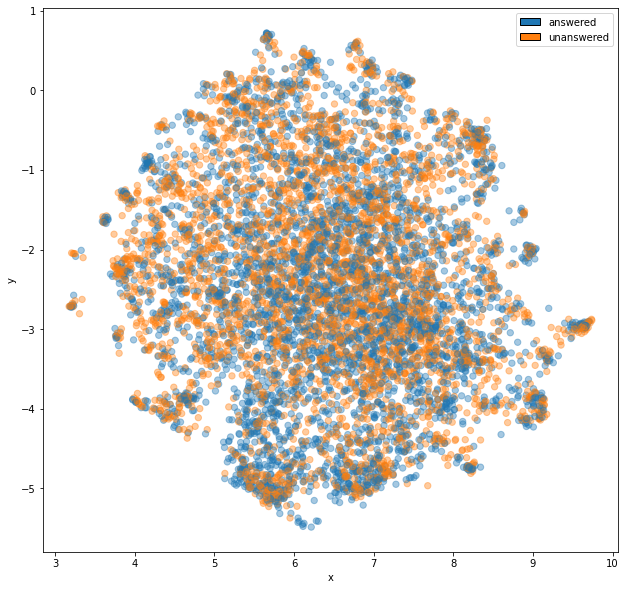

In [19]:
plot_embeddings(umap_bow, sent_labels)

This is a simplified representation of our data (the actual vectors are much larger than two dimensions), but can help discern trends, or with future labeling efforts. As you add features, it can be valuable to visualize embeddings to estimate whether classes look more separated.

# Pre-trained word embeddings

For this second approach, we load existing word vectors that were trained on a much larger corpus, which allows us to leverage general information from outside of our corpus. We will do so using the spacy library.

In [20]:
# Load a large model, and disable pipeline unnecessary parts for our task
# This speeds up the vectorization process significantly
# See https://spacy.io/models/en#en_core_web_lg for details about the model

nlp = spacy.load('en_core_web_lg', disable=['parser', 'tagger', 'ner'])

In [21]:
# Get the vector for each of our questions
# By default, the vector returned is the average of all vectors in the sentence
# See https://spacy.io/usage/vectors-similarity for more

spacy_emb = train_author[train_author['is_question']]['body_text'].apply(lambda x: nlp(x).vector)
embeddings = np.vstack(spacy_emb)

In [22]:
umap_embedder = umap.UMAP()
umap_emb = umap_embedder.fit_transform(embeddings)

Let's visualize the pretrained embeddings using UMAP

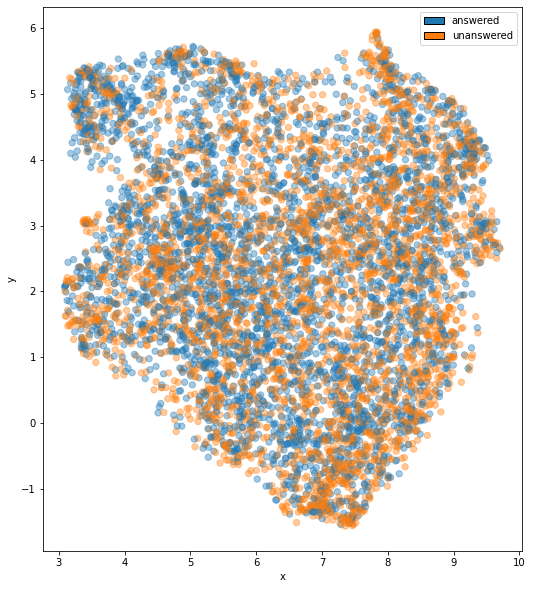

In [23]:
plot_embeddings(umap_emb, sent_labels)

The topology of our dataset looks different because our embedding method is different. The underlying data however, is the same.

Different embedding methods will cause a dataset to be represented differently. When using embeddings trained only on your data, documents that use the same vocabulary will be embedded close to each other. Using models trained on other corpuses however allows you to leverage information from these corpuses. With these models, semantically similar sentences may be embedded close to each other even if their vocabulary is completely different.

Changing the way you vectorize your data can often have a significant impact on model performance.